# Terphenyl Heteropolymer Analysis Notebook

In this notebook I will perform several data analysis on the RHH terphenyl octamer. This molecule has 3 aromatic moieties connected with peptide-linkers. Collaborators in the Gellman group, at U Wisc-Ma., have been trying to synthesize and characterize this molecule. This would represent a novel type of foldamer molecule.

## Replica Exchange Energy Distributions

For replica exchange data, it is imporant to see the overlap of energy states from each replica. For this reason we will look at the histogram of energies from each simulation and confirm that energies each replica is behaving as expected.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import panedr
import matplotlib.pyplot as plt
import numpy as np
import os
import pymbar
import mdtraj
import heat_capacity
import itertools
from scipy.constants import physical_constants, find
import tqdm
import plotting
import h_bonds

plt.style.use('ggplot')

In [4]:
energy_df = panedr.edr_to_df("/mnt/summit/simulations/octamer_Rchiral/RHH/remd_sim/225K_to_325K/sim0/npt.edr")
energy_df.head()

Time         Bond         Angle  Proper Dih.       LJ-14   Coulomb-14  \
0.0      0.0  3821.400879  15195.199219   515.260437  591.994446 -1047.726929   
100.0  100.0  3951.689697  14925.915039   493.858887  582.200317 -1057.283936   
200.0  200.0  3756.028809  15100.609375   495.191223  623.182983 -1056.179810   
300.0  300.0  3997.822266  15091.799805   504.088470  599.458862 -1050.571289   
400.0  400.0  3760.550781  15026.639648   522.764282  570.192627 -1057.086914   

            LJ (SR)  Disper. corr.  Coulomb (SR)  Coul. recip.  ...  \
0.0     1063.418091     -28.662003  -5275.471191   1292.465820  ...   
100.0 -24041.978516     -10.134899  -4304.611328    302.315979  ...   
200.0 -23884.673828     -10.070463  -4301.423340    353.991455  ...   
300.0 -24100.880859     -10.120700  -4341.618652    328.393677  ...   
400.0 -23996.125000     -10.100462  -4421.774414    332.130920  ...   

          Pres-YZ     Pres-ZX     Pres-ZY     Pres-ZZ  #Surf*SurfTen  \
0.0    115.141861  347.244385  115.143845  176.696198     615.206055   
100.0  167.786377  105.012726  167.786377  368.049103   -1063.313721   
200.0   48.791668  -49.580032   48.792316  348.390808    2802.044678   
300.0  -19.702532  373.134125  -19.701366   31.240614     726.304626   
400.0   -4.289162   78.835785   -4.288706  482.891907    2405.204102   

       Box-Vel-XX  Box-Vel-YY  Box-Vel-ZZ    T-System  Lamb-System  
0.0      0.000000    0.000000    0.000000  226.623932          1.0  
100.0    0.000116    0.000116    0.000116  226.282211          1.0  
200.0   -0.002121   -0.002121   -0.002121  226.030457          1.0  
300.0    0.001995    0.001995    0.001995  223.546173          1.0  
400.0    0.002528    0.002528    0.002528  225.371780          1.0  

[5 rows x 50 columns]

In [5]:
# Extract Potential Energies from each simulation
sim_dir_name = "sim"
path = "/mnt/summit/simulations/octamer_Rchiral/RHH/remd_sim/225K_to_325K/"
n_replicas = 20

energies, temps = heat_capacity.get_energies(sim_dir_name, path, n_replicas)

npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.part0005.edr
npt.part0006.edr
npt.part0007.edr
npt.part0008.edr
npt.part0009.edr
npt.part0010.edr
npt.part0011.edr
npt.part0012.edr
npt.part0013.edr
npt.part0014.edr
npt.part0015.edr
npt.part0016.edr
npt.part0017.edr
npt.part0018.edr
npt.part0019.edr
npt.part0020.edr
npt.part0021.edr
npt.part0022.edr
npt.part0023.edr
npt.part0024.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.part0005.edr
npt.part0006.edr
npt.part0007.edr
npt.part0008.edr
npt.part0009.edr
npt.part0010.edr
npt.part0011.edr
npt.part0012.edr
npt.part0013.edr
npt.part0014.edr
npt.part0015.edr
npt.part0016.edr
npt.part0017.edr
npt.part0018.edr
npt.part0019.edr
npt.part0020.edr
npt.part0021.edr
npt.part0022.edr
npt.part0023.edr
npt.part0024.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.part0005.edr
npt.part0006.edr
npt.part0007.edr
npt.part0008.edr
npt.part0009.edr
npt.part0010.edr
npt.part0011.edr
npt.part0012.edr
npt.par

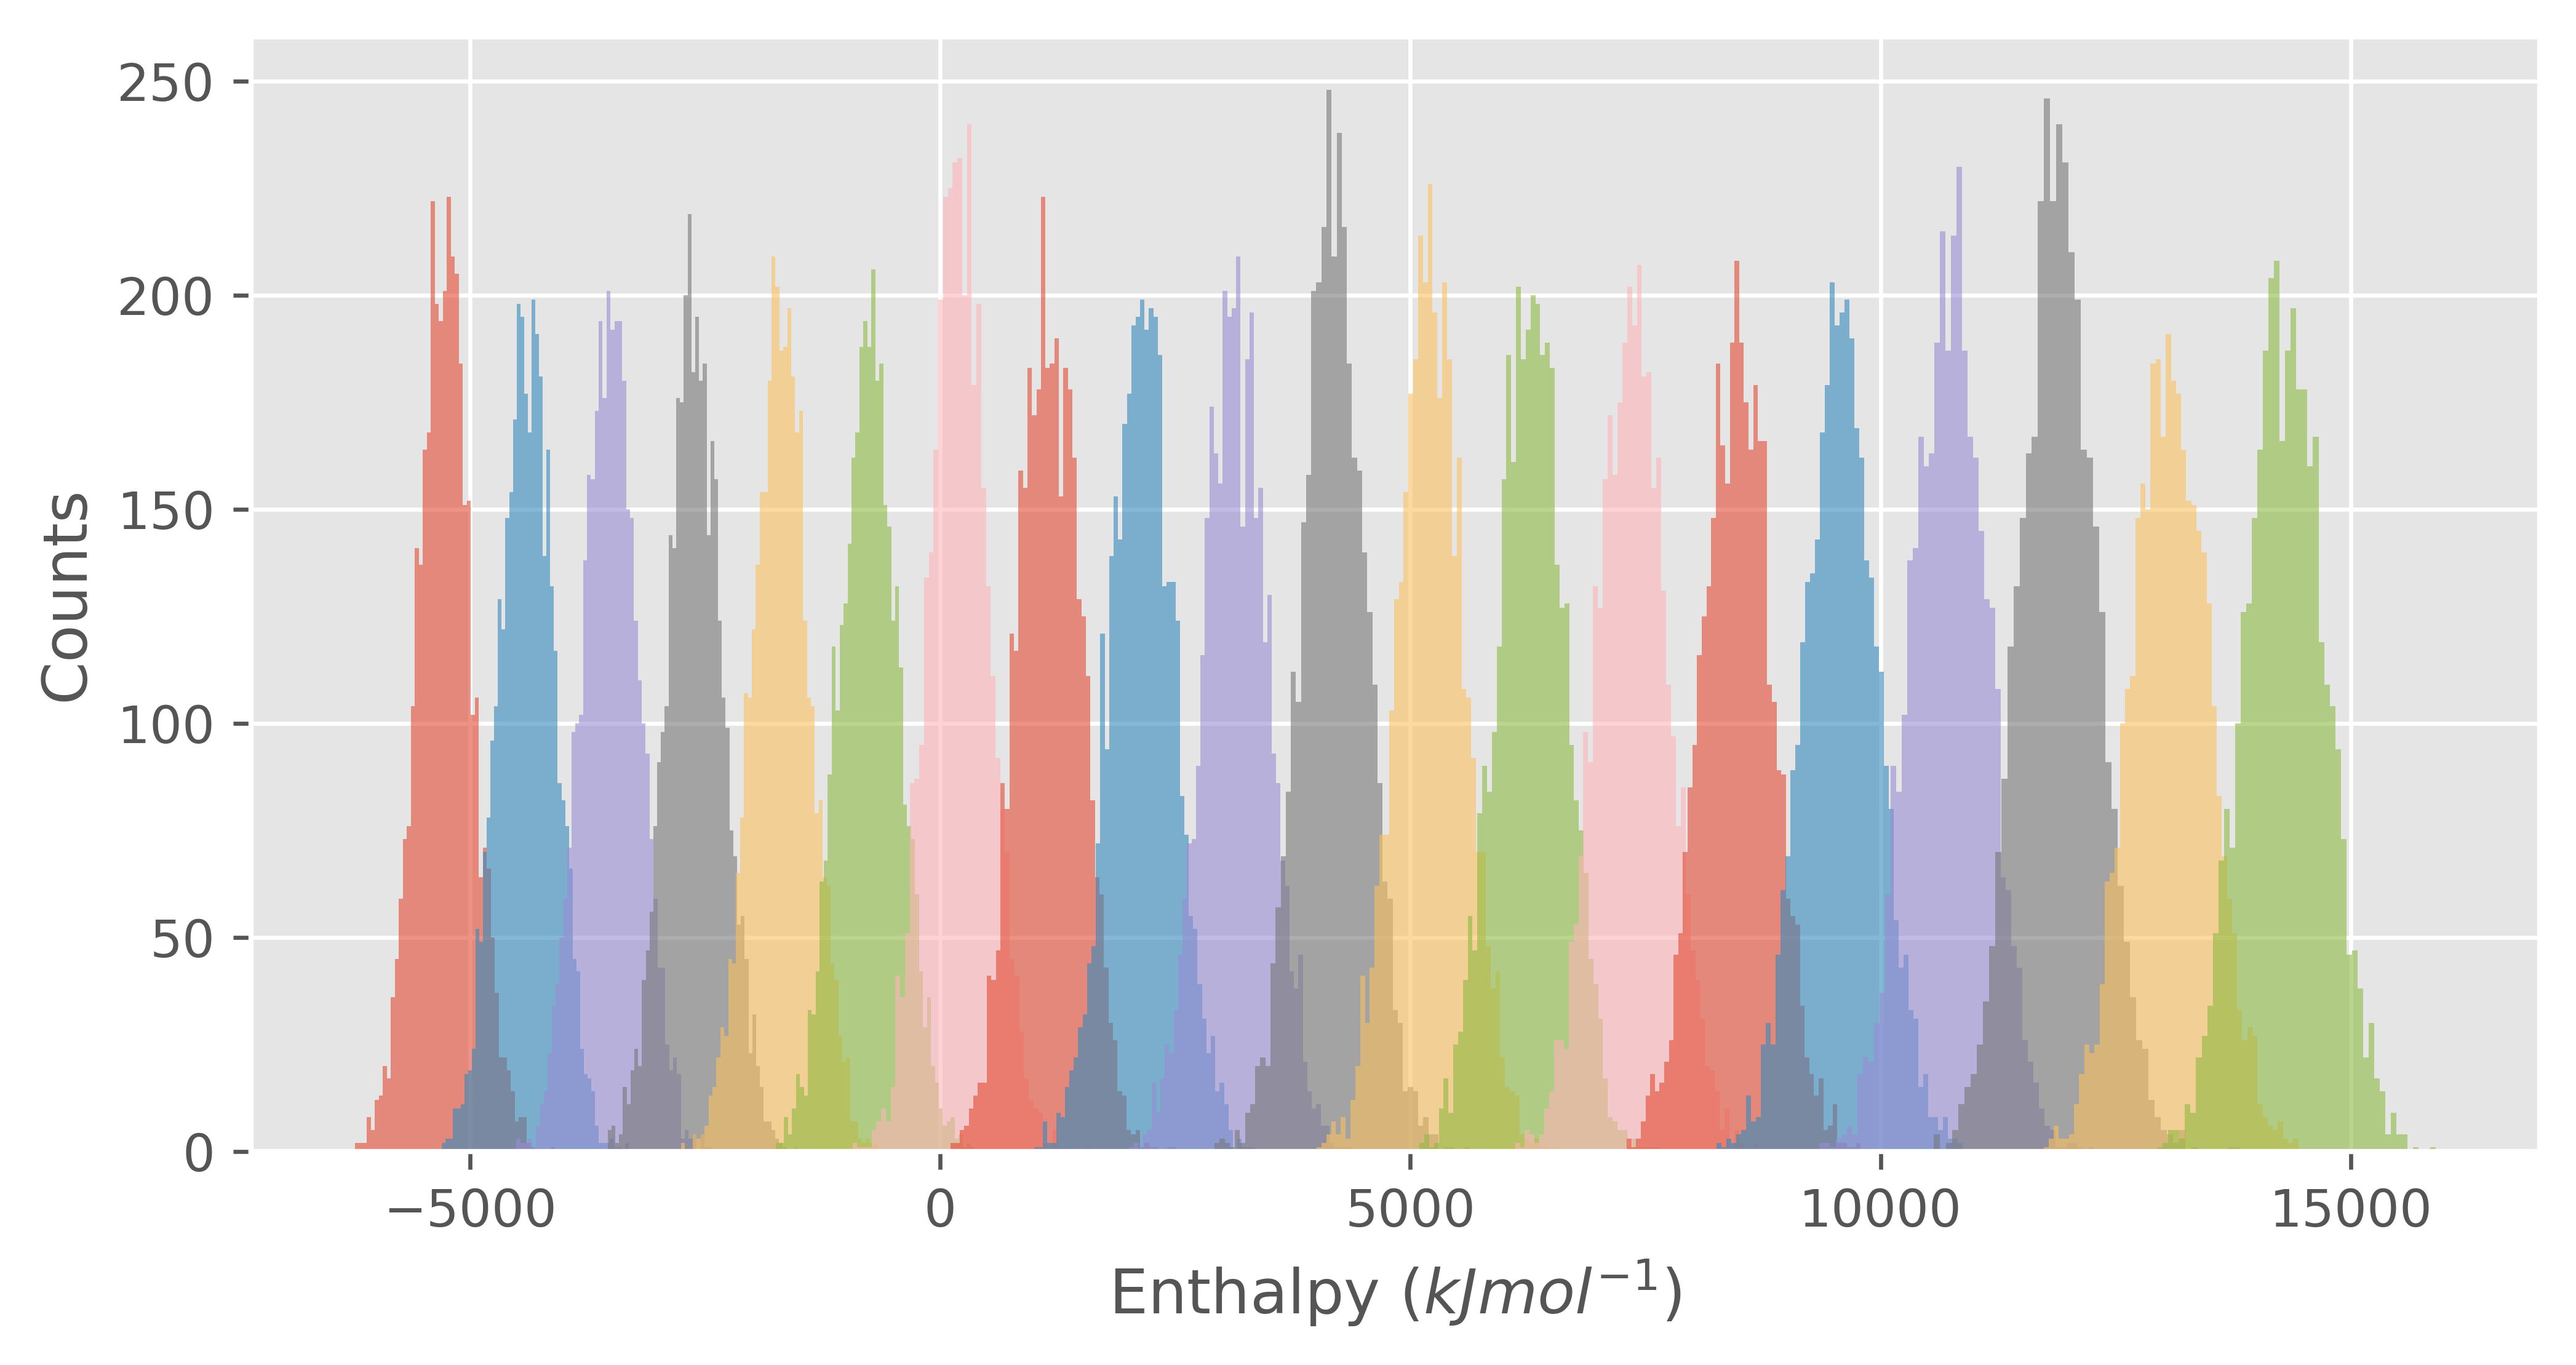

In [6]:
plotting.plot_RE_energy_distributions(energies)

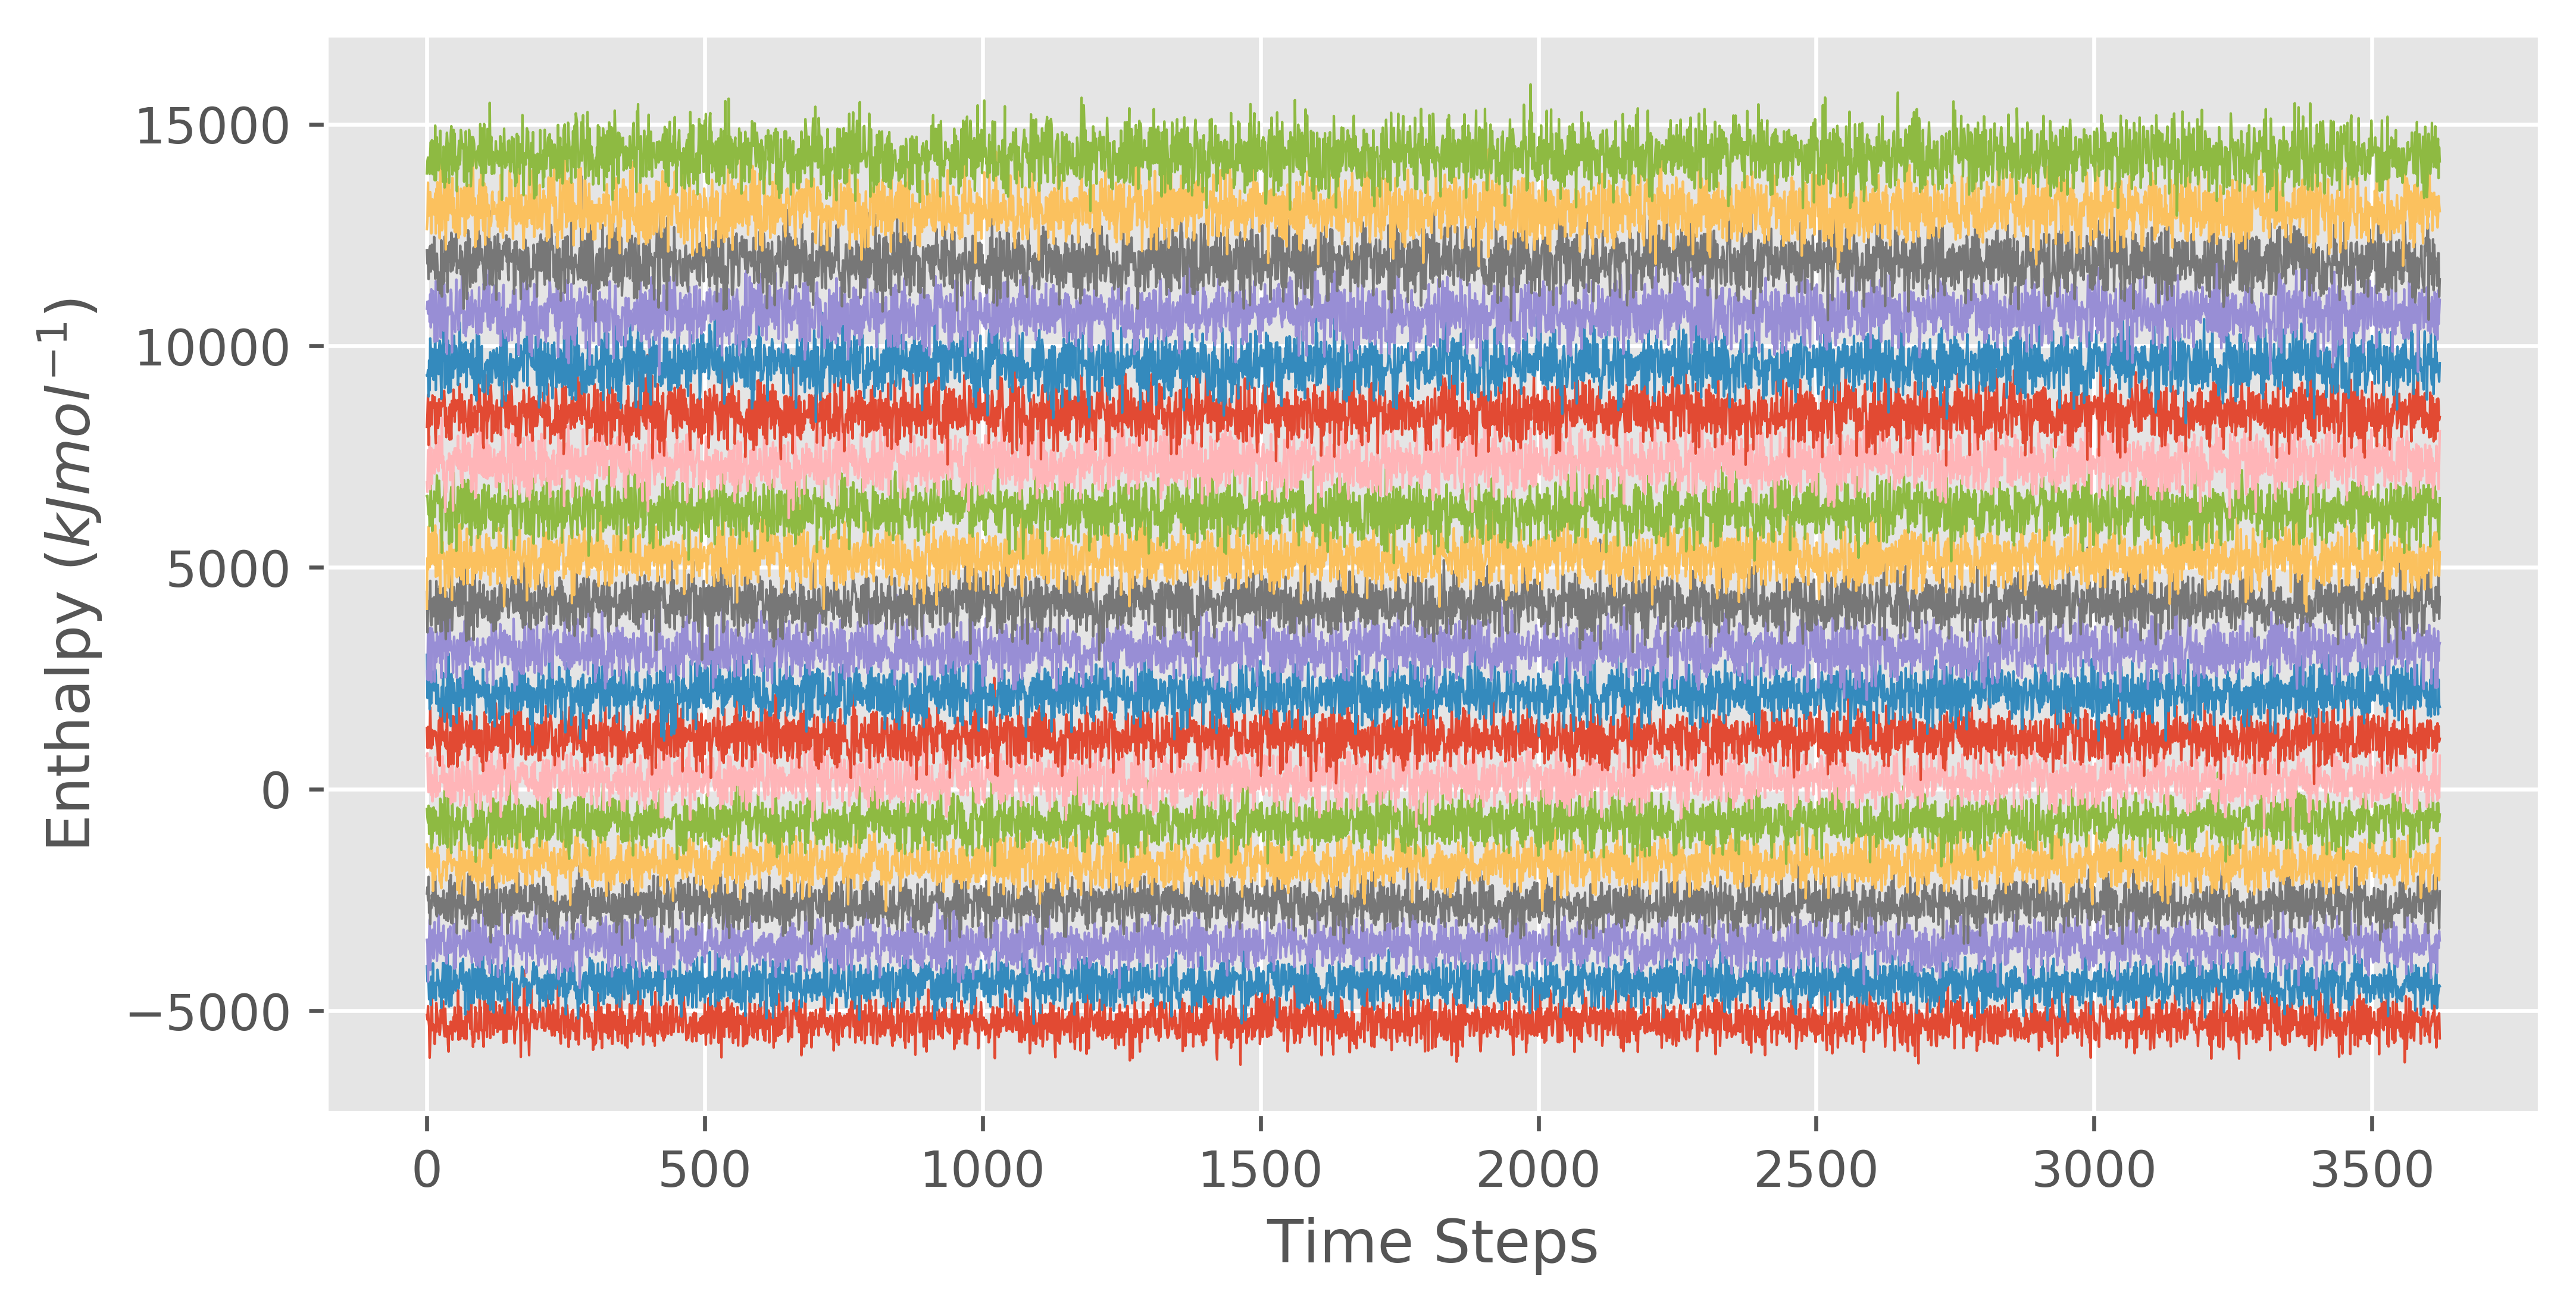

In [7]:
plotting.plot_RE_energy_trajectory(energies)

## Heat Capacity Curve

The nice thing about replica exchange simulations is we can compute the change of a systems heat capacity with temperature.This is especially useful for systems that experience large surface area changes during phase transistions, such as protein folding or melting transitions.

We'll be implementing heat capacity equation, using enthalpy:

$$C_p = \frac{d<H>}{dT}$$

We'll be calculating expectation heat capacities using the following formulas:



In [8]:
u_kln, n_samples, t_list, betas = heat_capacity.construct_u_kln_matrix(temps, energies, add_temps = np.linspace(225, 325, 200))

In [9]:
# MBAR
mbar = pymbar.MBAR(u_kln, n_samples, verbose = True, relative_tolerance = 1e-10, initial_f_k= None, maximum_iterations=1000)

K (total states) = 220, total samples = 72480

They are therefore likely to to be the same thermodynamic state.  This can occasionally cause
numerical problems with computing the covariance of their energy difference, which must be
identically zero in any case. Consider combining them into a single state.


They are therefore likely to to be the same thermodynamic state.  This can occasionally cause
numerical problems with computing the covariance of their energy difference, which must be
identically zero in any case. Consider combining them into a single state.

N_k = 
[3624 3624 3624 3624 3624 3624 3624 3624 3624 3624 3624 3624 3624 3624
 3624 3624 3624 3624 3624 3624    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0   

In [10]:
# Building potential energy kln matrix
E_kln = u_kln
for k in range(u_kln.shape[1]):
    E_kln[:,k,:] *= betas[k]**(-1)

# mean and variance of energy
results = mbar.computeExpectations(E_kln, state_dependent=True, return_dict=True)
E_expected = results['mu']
dE_expected = results['sigma']

In [11]:
# mean and variance of difference of energies
results = mbar.computeExpectations(E_kln, output='differences', state_dependent=True, return_dict=True)
DeltaE_expected = results['mu']
dDeltaE_expected = results['sigma']

A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


In [12]:
# mean and variance of energies squared
results = mbar.computeExpectations(E_kln**2, state_dependent=True, return_dict=True)
E2_expected = results['mu']
dE2_expected = results['sigma']

In [13]:
kb = physical_constants["Boltzmann constant"][0] *  physical_constants["Avogadro constant"][0] / 1000 # J (molK)^-1

Cp_expect = (E2_expected - (E_expected*E_expected)) / (kb * t_list**2)

In [14]:
Cp_expect = heat_capacity.calculate_cp(mbar, E_kln, t_list)

A squared uncertainty is negative. Largest Magnitude = 0.000000


Text(0.5, 0, 'Temperature (K)')

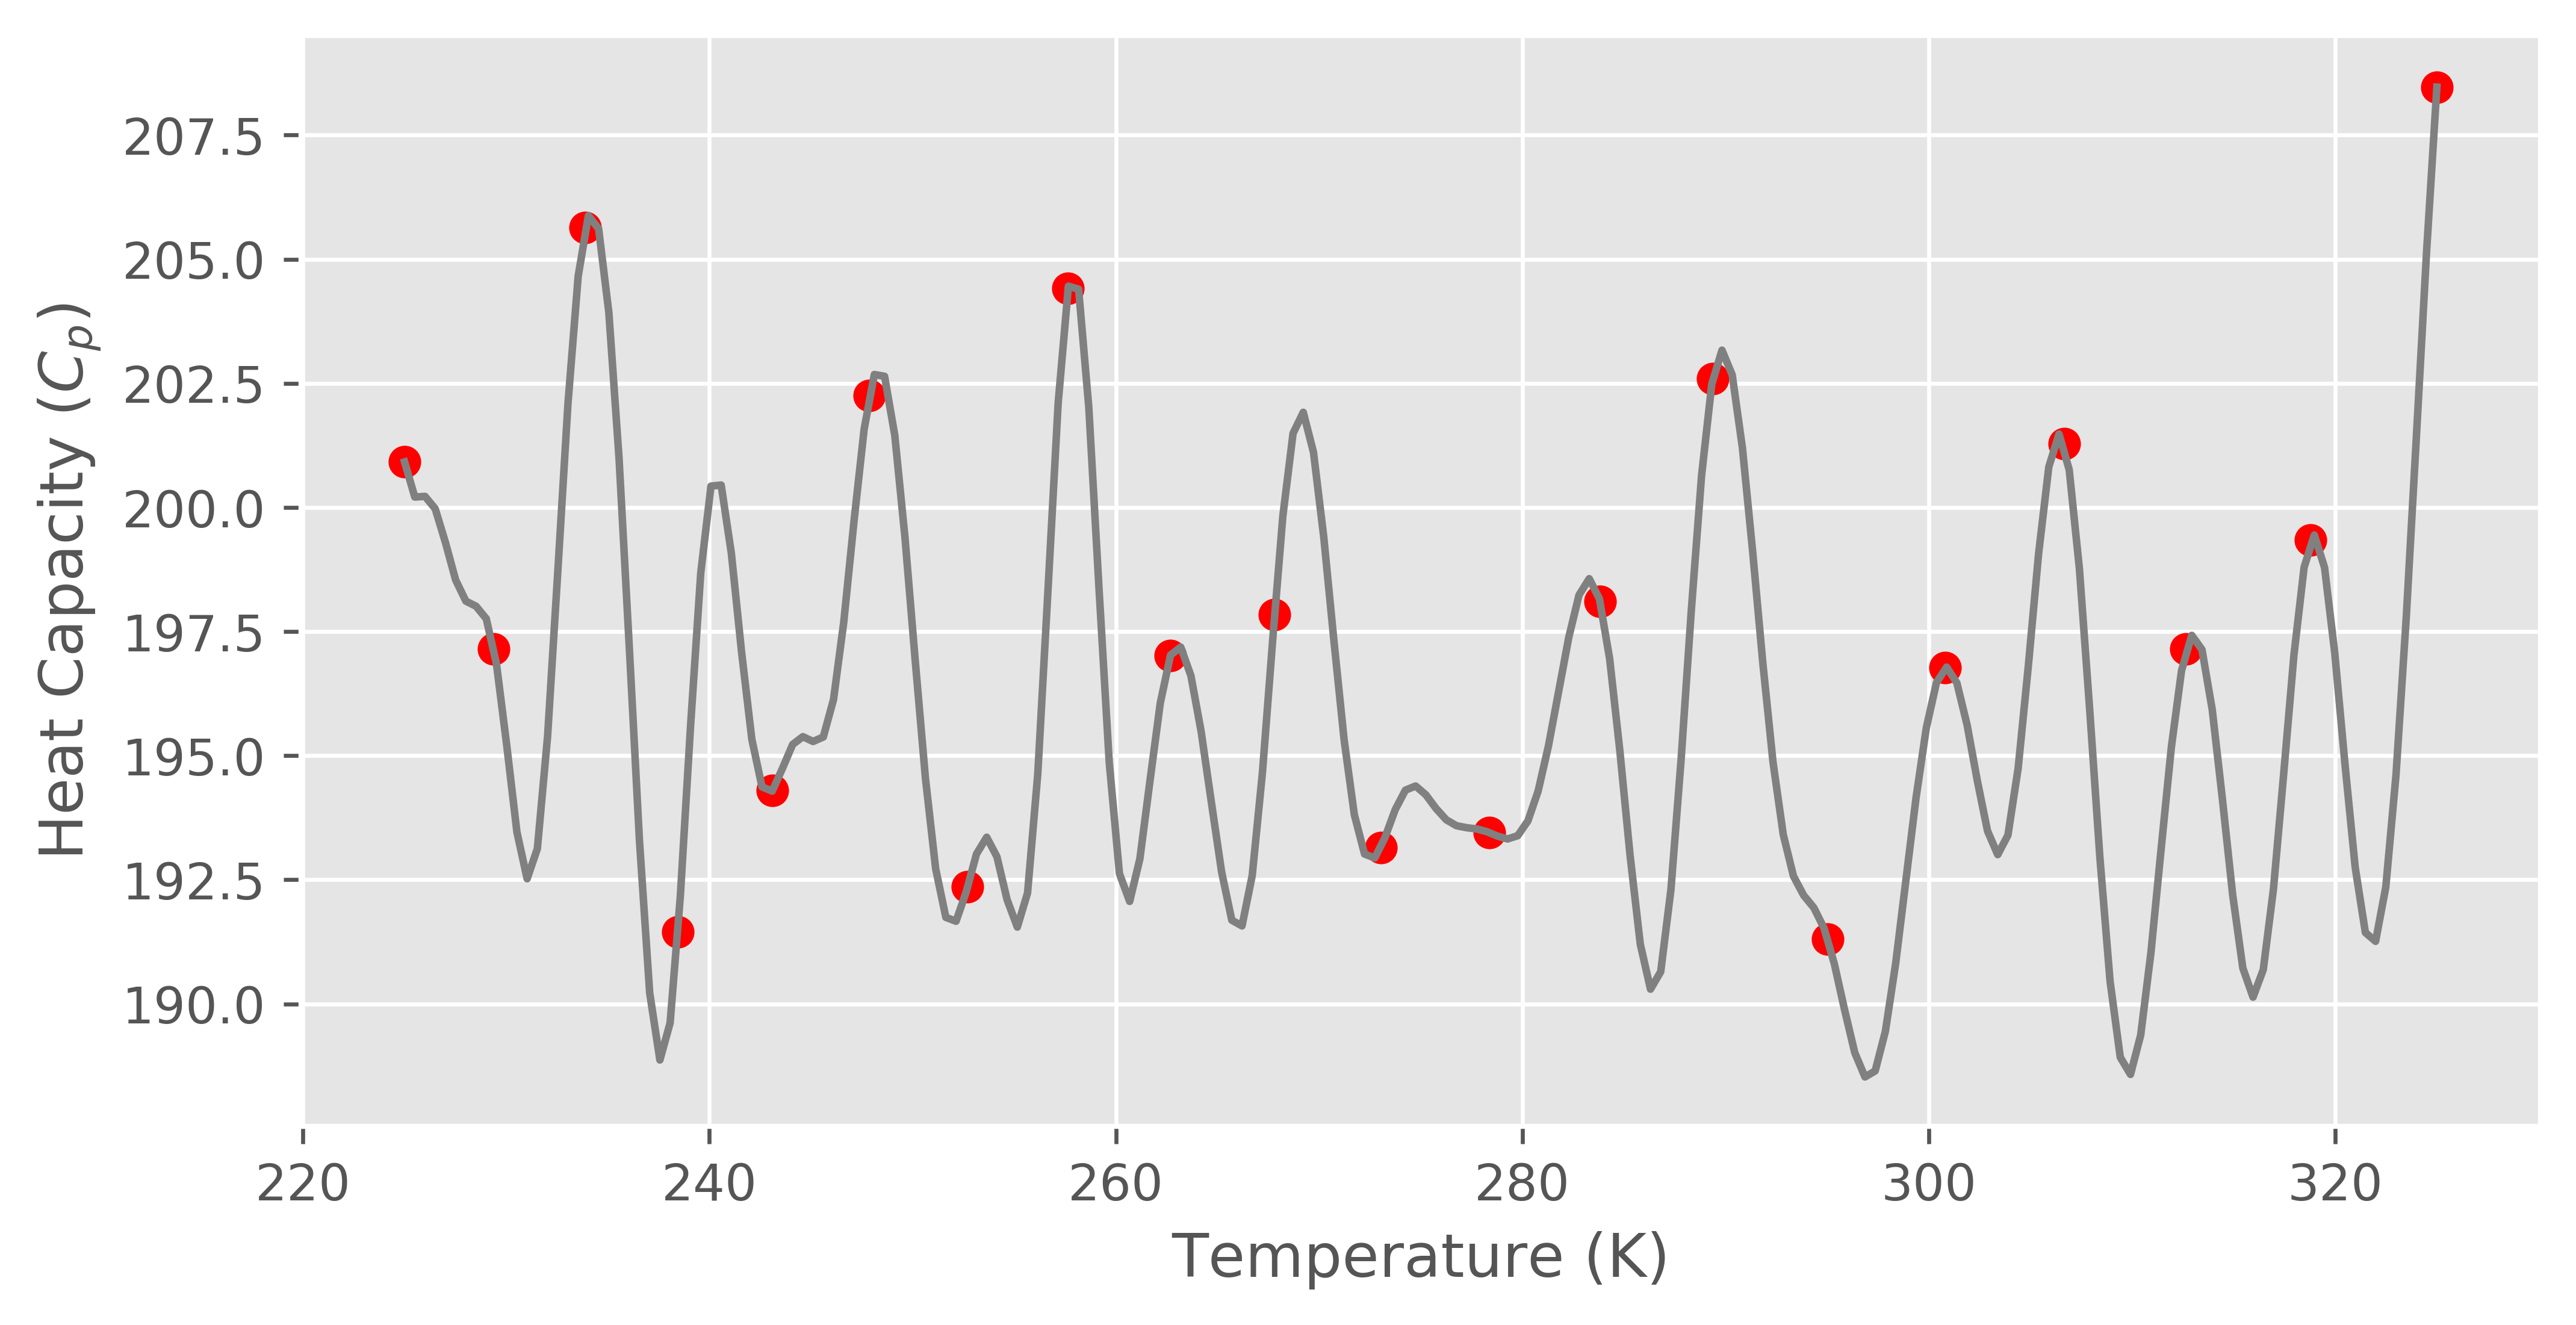

In [15]:
plt.figure(figsize=[8,4], dpi=600)
plt.plot(t_list[20:], Cp_expect[20:], color = "gray")
plt.scatter(t_list[:20], Cp_expect[:20], color = "red")
plt.ylabel("Heat Capacity ($C_p$)")
plt.xlabel("Temperature (K)")

## Bootstrapping Cp Results

We can use bootstrapping to generate uncertainties in our data set.

In [16]:
# Attempted to multiprocess the MBAR Bootstrapping
# But it appears that the optimizations in pymbar parallelize to use all processors
# Or the single process of mbar is extremely memory intensive

def cp_bootstrap(j):
    print("Working on bootstrap", j,"...")
    t1 = time.time()
    energies_boot = []
    for i in range(len(energies)):
        energies_boot.append(np.random.choice(energies[i], size=len(energies[i])))
    # Solve MBAR equations
    u_kln_boot, n_samples_boot, t_list_boot, betas_boot = heat_capacity.construct_u_kln_matrix(temps, energies_boot, add_temps = np.linspace(230, 325, 200))
    mbar_boot = pymbar.MBAR(u_kln_boot, n_samples_boot, verbose = False, relative_tolerance = 1e-10, initial_f_k= None, maximum_iterations=1000)
    # Compute expectations and variance of relevant terms
    E_kln_boot = u_kln_boot
    for k in range(u_kln_boot.shape[1]):
        E_kln_boot[:,k,:] *= betas_boot[k]**(-1)
    Cp_boot = heat_capacity.calculate_cp(mbar_boot, E_kln_boot, t_list)
    # compute boot strap cp
    t2 = time.time()
    print("bootstraj", j, "took", t2-t1, "seconds")
    return(Cp_boot)
    

In [17]:
from multiprocessing import Pool
import time

N_boots = 100
pool = Pool(2)

cp_boot = pool.map(cp_bootstrap, range(N_boots))

Working on bootstrap 0 ...
Working on bootstrap 13 ...
bootstraj 13 took 25.443042039871216 seconds
bootstraj 0 took 25.499164819717407 seconds
Working on bootstrap 1 ...
Working on bootstrap 14 ...
bootstraj 1 took 13.029980421066284 seconds
Working on bootstrap 2 ...
bootstraj 14 took 13.304632186889648 seconds
Working on bootstrap 15 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 2 took 12.291985750198364 seconds
Working on bootstrap 3 ...
bootstraj 15 took 12.56152892112732 seconds
Working on bootstrap 16 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 3 took 12.078963279724121 seconds
Working on bootstrap 4 ...
bootstraj 16 took 12.153977870941162 seconds
Working on bootstrap 17 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 4 took 12.319965839385986 seconds
Working on bootstrap 5 ...
bootstraj 17 took 12.284999132156372 seconds
Working on bootstrap 18 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 5 took 12.111130952835083 seconds
Working on bootstrap 6 ...
bootstraj 18 took 12.59520959854126 seconds
Working on bootstrap 19 ...
bootstraj 6 took 12.182660818099976 seconds
Working on bootstrap 7 ...
bootstraj 19 took 11.979354858398438 seconds
Working on bootstrap 20 ...
bootstraj 7 took 12.003698110580444 seconds
Working on bootstrap 8 ...
bootstraj 20 took 12.108911514282227 seconds
Working on bootstrap 21 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 8 took 12.104838609695435 seconds
Working on bootstrap 9 ...
bootstraj 21 took 11.834094285964966 seconds
Working on bootstrap 22 ...
bootstraj 9 took 12.14069652557373 seconds
Working on bootstrap 10 ...
bootstraj 22 took 11.837448596954346 seconds
Working on bootstrap 23 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 10 took 11.947549104690552 seconds
Working on bootstrap 11 ...
bootstraj 23 took 12.085150718688965 seconds
Working on bootstrap 24 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 11 took 12.379769802093506 seconds
Working on bootstrap 12 ...
bootstraj 24 took 12.095709323883057 seconds
Working on bootstrap 25 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 12 took 12.11863088607788 seconds
Working on bootstrap 26 ...
bootstraj 25 took 12.28212857246399 seconds
Working on bootstrap 39 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 26 took 12.404898166656494 seconds
Working on bootstrap 27 ...
bootstraj 39 took 12.482009887695312 seconds
Working on bootstrap 40 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 27 took 12.340972423553467 seconds
Working on bootstrap 28 ...
bootstraj 40 took 12.625768661499023 seconds
Working on bootstrap 41 ...
bootstraj 28 took 12.179100275039673 seconds
Working on bootstrap 29 ...
bootstraj 41 took 12.262588739395142 seconds
Working on bootstrap 42 ...
bootstraj 29 took 12.04434609413147 seconds
Working on bootstrap 30 ...
bootstraj 42 took 11.683351278305054 seconds
Working on bootstrap 43 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 30 took 12.153616666793823 seconds
Working on bootstrap 31 ...
bootstraj 43 took 12.233441829681396 seconds
Working on bootstrap 44 ...
bootstraj 31 took 12.497857809066772 seconds
bootstraj 44 took 12.267794370651245 seconds
Working on bootstrap 32 ...
Working on bootstrap 45 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 32 took 12.398488283157349 seconds
Working on bootstrap 33 ...
bootstraj 45 took 12.639034271240234 seconds
Working on bootstrap 46 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 33 took 12.451828002929688 seconds
Working on bootstrap 34 ...
bootstraj 46 took 12.560959339141846 seconds
Working on bootstrap 47 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 34 took 12.099106311798096 seconds
Working on bootstrap 35 ...
bootstraj 47 took 12.067817687988281 seconds
Working on bootstrap 48 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 35 took 12.027165651321411 seconds
Working on bootstrap 36 ...
bootstraj 48 took 12.474754810333252 seconds
Working on bootstrap 49 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 36 took 12.028252840042114 seconds
Working on bootstrap 37 ...
bootstraj 49 took 11.973681926727295 seconds
Working on bootstrap 50 ...
bootstraj 37 took 12.203514575958252 seconds
Working on bootstrap 38 ...
bootstraj 50 took 12.011720180511475 seconds
Working on bootstrap 51 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 38 took 12.50360655784607 seconds
Working on bootstrap 52 ...
bootstraj 51 took 12.15638017654419 seconds
Working on bootstrap 65 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 65 took 12.233824729919434 seconds
Working on bootstrap 66 ...
bootstraj 52 took 12.62931752204895 seconds
Working on bootstrap 53 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 66 took 11.990439653396606 seconds
Working on bootstrap 67 ...
bootstraj 53 took 12.100650548934937 seconds
Working on bootstrap 54 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 67 took 12.1076819896698 seconds
Working on bootstrap 68 ...
bootstraj 54 took 12.090590953826904 seconds
Working on bootstrap 55 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 68 took 12.689514875411987 seconds
bootstraj 55 took 12.539799690246582 seconds
Working on bootstrap 69 ...
Working on bootstrap 56 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 69 took 12.305620431900024 seconds
Working on bootstrap 70 ...
bootstraj 56 took 12.493861436843872 seconds
Working on bootstrap 57 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 70 took 12.557946681976318 seconds
Working on bootstrap 71 ...
bootstraj 57 took 12.582618951797485 seconds
Working on bootstrap 58 ...
bootstraj 71 took 12.206030130386353 seconds
Working on bootstrap 72 ...
bootstraj 58 took 12.328136682510376 seconds
Working on bootstrap 59 ...
bootstraj 72 took 12.242387533187866 seconds
Working on bootstrap 73 ...
bootstraj 59 took 12.19377875328064 seconds
Working on bootstrap 60 ...
bootstraj 73 took 11.9051673412323 seconds
Working on bootstrap 74 ...
bootstraj 60 took 12.010935306549072 seconds
Working on bootstrap 61 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 74 took 11.853415727615356 seconds
Working on bootstrap 75 ...
bootstraj 61 took 11.944377183914185 seconds
Working on bootstrap 62 ...
bootstraj 75 took 12.359811305999756 seconds
Working on bootstrap 76 ...
bootstraj 62 took 12.233006000518799 seconds
Working on bootstrap 63 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 76 took 12.268619298934937 seconds
Working on bootstrap 77 ...
bootstraj 63 took 12.062898397445679 seconds
Working on bootstrap 64 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 64 took 12.342421770095825 seconds
bootstraj 77 took 12.562845230102539 seconds
Working on bootstrap 78 ...
Working on bootstrap 91 ...
bootstraj 78 took 12.474294662475586 seconds
bootstraj 91 took 12.495801448822021 seconds
Working on bootstrap 79 ...
Working on bootstrap 92 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 92 took 12.14539098739624 seconds
Working on bootstrap 93 ...
bootstraj 79 took 12.463805913925171 seconds
Working on bootstrap 80 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 93 took 12.381331205368042 seconds
Working on bootstrap 94 ...
bootstraj 80 took 12.234697341918945 seconds
Working on bootstrap 81 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 94 took 12.224549531936646 seconds
Working on bootstrap 95 ...
bootstraj 81 took 12.307302474975586 seconds
Working on bootstrap 82 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 95 took 12.124776840209961 seconds
Working on bootstrap 96 ...
bootstraj 82 took 12.051764726638794 seconds
Working on bootstrap 83 ...
bootstraj 96 took 11.922649383544922 seconds
Working on bootstrap 97 ...
bootstraj 83 took 12.147066831588745 seconds
Working on bootstrap 84 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 97 took 12.355180501937866 seconds
Working on bootstrap 98 ...
bootstraj 84 took 12.32401990890503 seconds
Working on bootstrap 85 ...
bootstraj 98 took 12.013597249984741 seconds
Working on bootstrap 99 ...
bootstraj 85 took 11.978646755218506 seconds
Working on bootstrap 86 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 99 took 12.235816478729248 seconds
bootstraj 86 took 12.208617925643921 seconds
Working on bootstrap 87 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 87 took 9.568782329559326 seconds
Working on bootstrap 88 ...
A squared uncertainty is negative. Largest Magnitude = 0.000000


/home/lenny/anaconda3/envs/terphenyl/lib/python3.8/site-packages/pymbar/mbar.py:1593: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(d2))


bootstraj 88 took 9.662808418273926 seconds
Working on bootstrap 89 ...
bootstraj 89 took 9.40610957145691 seconds
Working on bootstrap 90 ...
bootstraj 90 took 9.614635944366455 seconds


In [18]:
cp_boot = np.array(cp_boot)

In [19]:
mu_cp_boot = np.mean(cp_boot, axis = 0)
sigma_cp_boot = np.std(cp_boot, axis = 0)

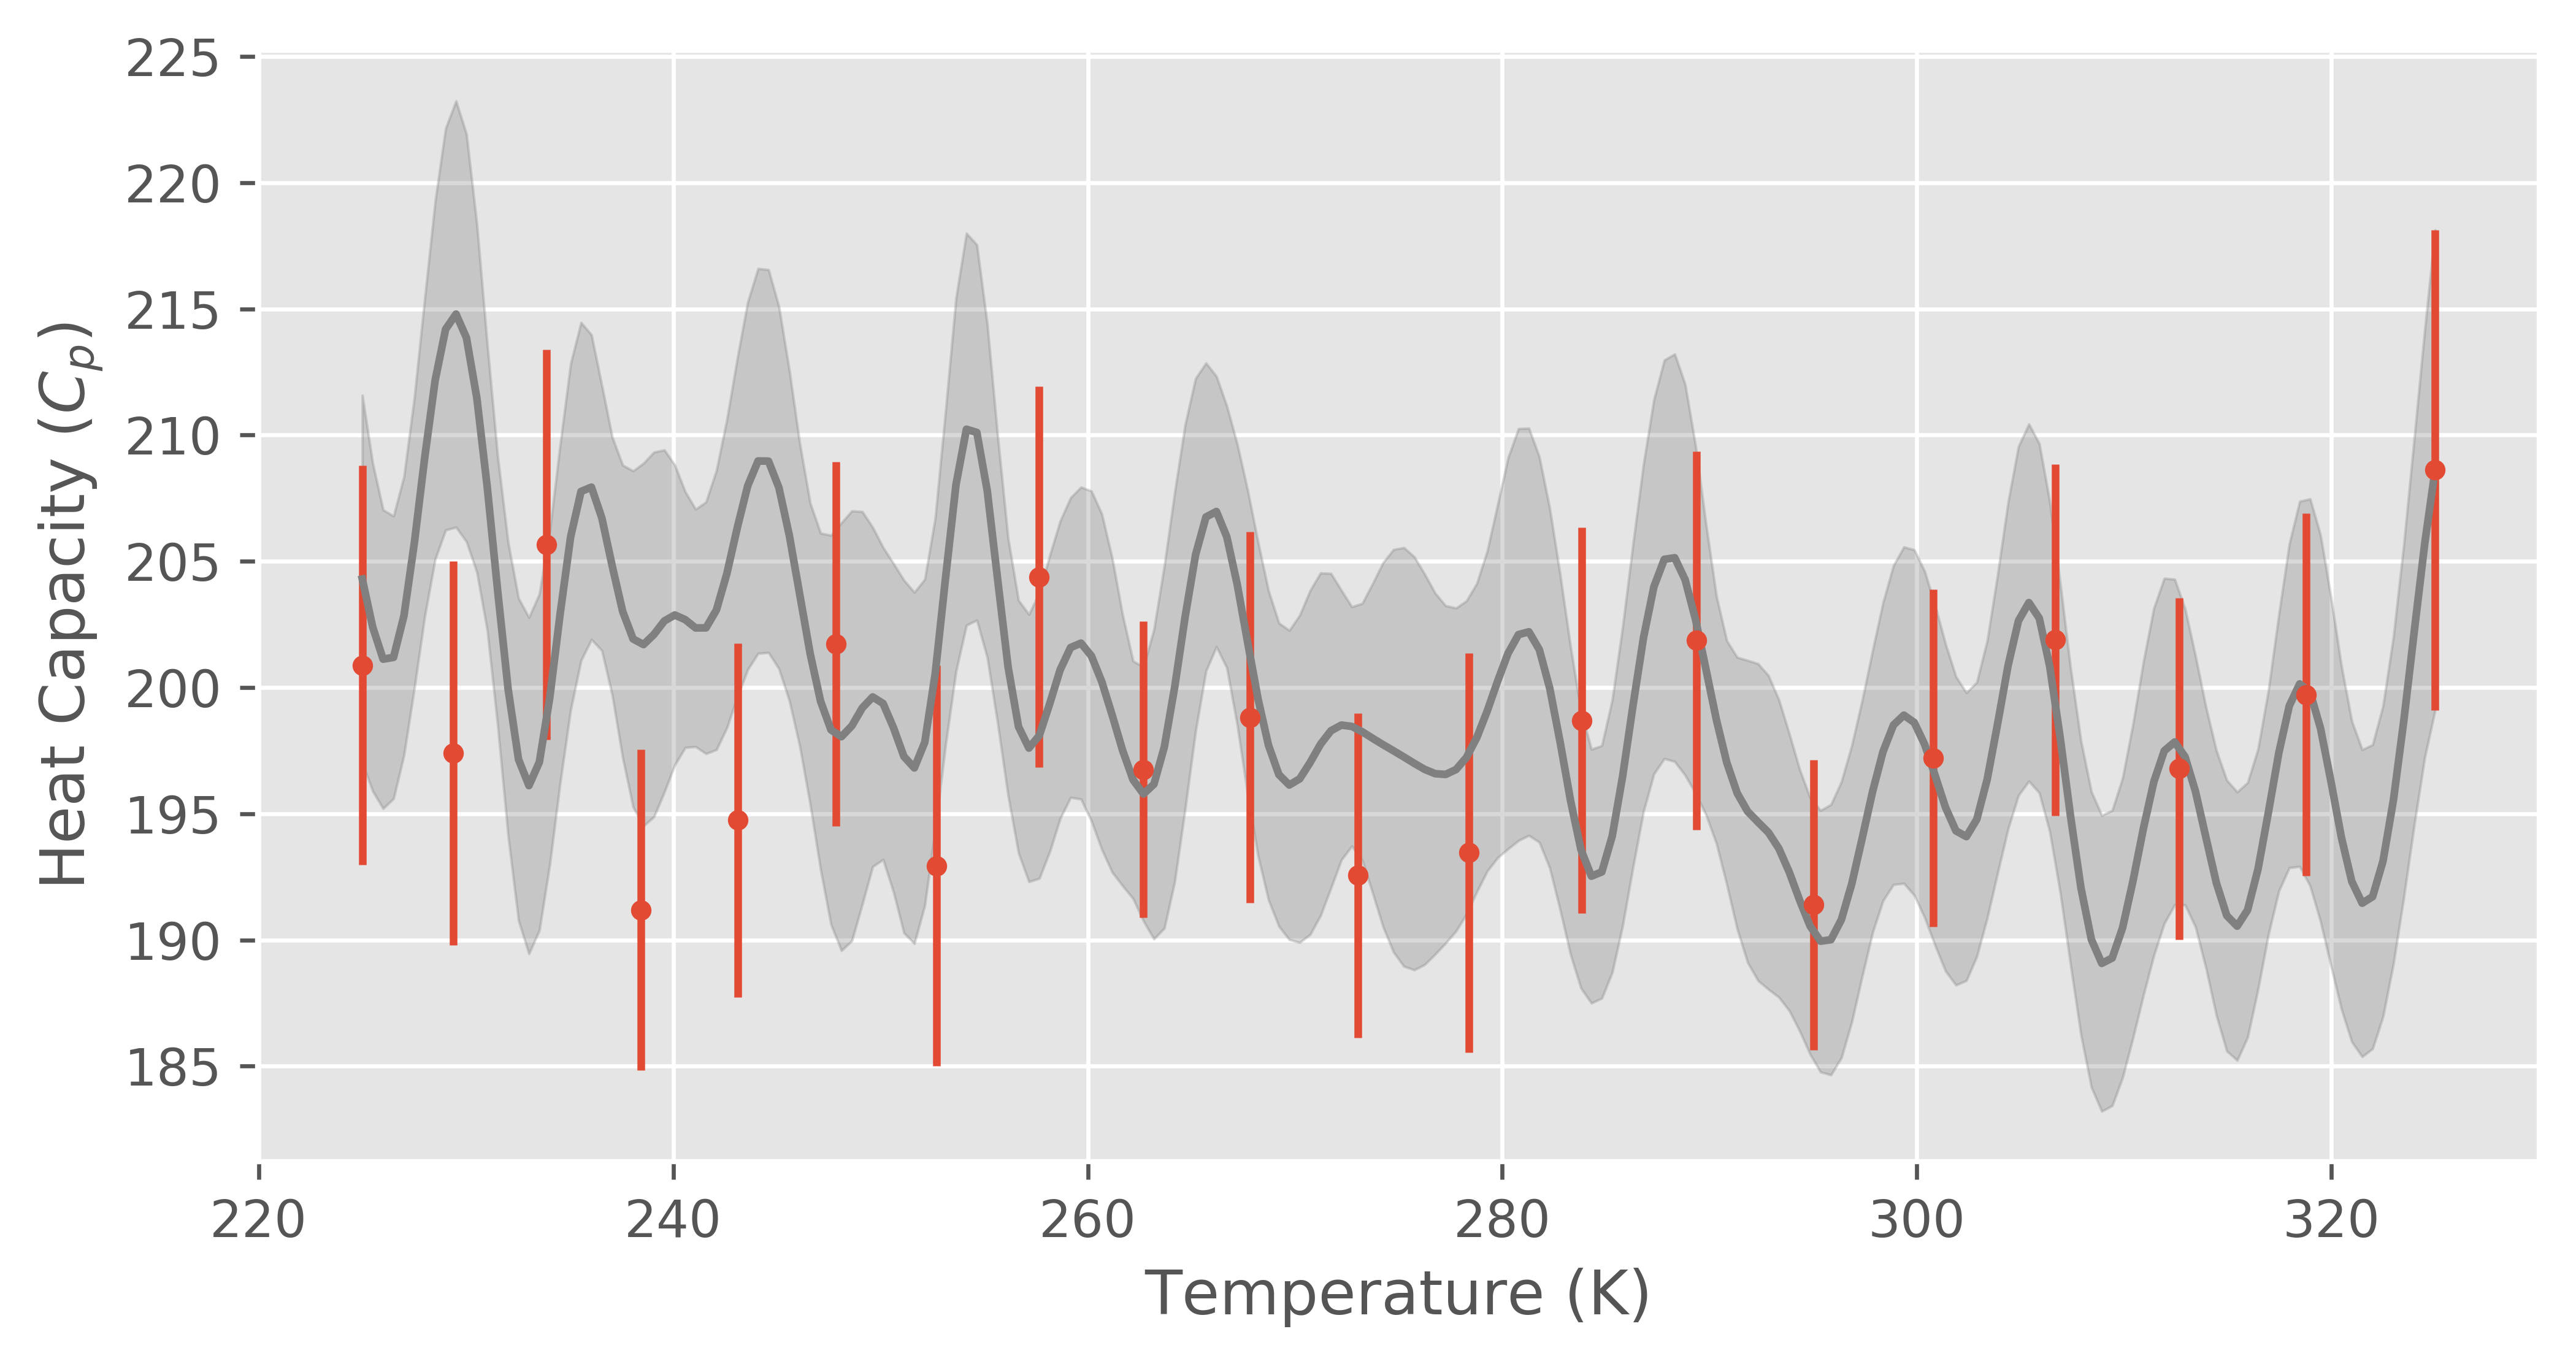

In [20]:
plotting.plot_bootstrapped_heat_capacity(mu_cp_boot, sigma_cp_boot, t_list, 20)

## H-Bonding with Temperature

Since we're unsure whether the Cp spike we're observing at 225 K is due to the solvent or the molecule, we need to investigate the average hydrogen bonds formed in each replica simulation. This will confirm if there is a significant change in the number of hydrogen bonds at low temperatures, indicating that the terphenyl molecule may be giving rise to the large heat capacity spike.

In [21]:
remd_trajs = h_bonds.REMD_trajectories("/mnt/summit/simulations/octamer_Rchiral/RHH/remd_sim/225K_to_325K", "npt", "whole.xtc","sim", "/mnt/summit/simulations/octamer_Rchiral/RHH/remd_sim/225K_to_325K/sim0/berendsen.gro", np = 10)

Replica 3
Replica 1
Replica 5
Replica 0
Replica 2
Replica 4
Replica 8
Replica 9
Replica 7
Replica 6
npt.part0002.whole.xtc
npt.part0002.whole.xtc
npt.part0002.whole.xtc
npt.part0002.whole.xtc
npt.part0003.whole.xtc
npt.part0003.whole.xtc
npt.part0003.whole.xtc
npt.part0002.whole.xtc
npt.part0004.whole.xtc
npt.part0003.whole.xtc
npt.part0004.whole.xtc
npt.part0004.whole.xtc
npt.part0005.whole.xtc
npt.part0005.whole.xtc
npt.part0004.whole.xtc
npt.part0005.whole.xtc
npt.part0006.whole.xtc
npt.part0006.whole.xtc
npt.part0007.whole.xtc
npt.part0005.whole.xtc
npt.part0007.whole.xtc
npt.part0003.whole.xtc
npt.part0008.whole.xtc
npt.part0006.whole.xtc
npt.part0004.whole.xtc
npt.part0009.whole.xtc
npt.part0008.whole.xtc
npt.part0006.whole.xtc
npt.part0009.whole.xtc
npt.part0005.whole.xtc
npt.part0010.whole.xtc
npt.part0007.whole.xtc
npt.part0006.whole.xtc
npt.part0011.whole.xtc
npt.part0008.whole.xtc
npt.part0010.whole.xtc
npt.part0007.whole.xtc
npt.part0007.whole.xtc
npt.part0008.whole.xtc
npt

npt.part0021.whole.xtc
npt.part0022.whole.xtc
npt.part0023.whole.xtc
npt.part0024.whole.xtc
npt.whole.xtc
npt.part0002.whole.xtc
npt.part0003.whole.xtc
npt.part0004.whole.xtc
npt.part0005.whole.xtc
npt.part0006.whole.xtc
npt.part0007.whole.xtc
npt.part0008.whole.xtc
npt.part0009.whole.xtc
npt.part0010.whole.xtc
npt.part0011.whole.xtc
npt.part0012.whole.xtc
npt.part0013.whole.xtc
npt.part0014.whole.xtc
npt.part0015.whole.xtc
npt.part0016.whole.xtc
npt.part0017.whole.xtc
npt.part0018.whole.xtc
npt.part0019.whole.xtc
npt.part0020.whole.xtc
npt.part0021.whole.xtc
npt.part0022.whole.xtc
npt.part0023.whole.xtc
npt.part0024.whole.xtc
npt.whole.xtc
Replica 16
Replica 17
npt.part0002.whole.xtc
npt.part0003.whole.xtc
npt.part0004.whole.xtc
npt.part0005.whole.xtc
npt.part0006.whole.xtc
npt.part0007.whole.xtc
npt.part0008.whole.xtc
npt.part0009.whole.xtc
npt.part0010.whole.xtc
npt.part0011.whole.xtc
npt.part0012.whole.xtc
npt.part0013.whole.xtc
npt.part0014.whole.xtc
npt.part0015.whole.xtc
npt.par

In [22]:
remd_trajs.trajs[0][0].top

<mdtraj.Topology with 1 chains, 1262 residues, 6678 atoms, 0 bonds at 0x7f5dfd0b5fa0>

In [23]:
h_bond_finder = h_bonds.HydrogenBondFinder(remd_trajs.trajs[0][0], remd_trajs.trajs[0][0].top)
h_bond_finder.get_donors()
h_bond_finder.get_acceptors()
n_h_bonds, h_bond_ids = h_bond_finder.get_hydrogen_bonds(remd_trajs.trajs[0])

100%|██████████| 3624/3624 [00:01<00:00, 1817.37it/s]


In [24]:
pool = Pool(8)

100%|██████████| 3624/3624 [00:02<00:00, 1610.49it/s]


In [25]:
n_h_bonds_remd, h_bonds_remd = zip(*pool.map(h_bond_finder.get_hydrogen_bonds, remd_trajs.trajs))

In [26]:
n_h_bonds_remd = np.array(n_h_bonds_remd)
h_bonds_remd = h_bonds_remd

In [27]:
temps = np.array(remd_trajs.temps)

Text(0.5, 0, 'Replica Temperature')

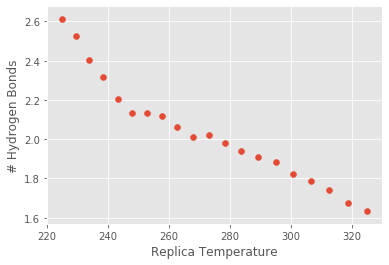

In [28]:
plt.scatter(temps, np.mean(n_h_bonds_remd, axis = 1))
plt.ylabel("# Hydrogen Bonds")
plt.xlabel("Replica Temperature")

In [29]:
n_h_bonds_remd.shape

(20, 3624)

In [30]:
h_bonds_kln = np.zeros(u_kln.shape)
for k in range(replica_n_h_bonds.shape[0]):
    for l in range(h_bonds_kln.shape[0]):
        h_bonds_kln[k,l,:] = replica_n_h_bonds[k]

NameError: name 'replica_n_h_bonds' is not defined

In [ ]:
E_kln.shape